<a href="https://colab.research.google.com/github/SONINJE/AI_system/blob/main/6%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5%EA%B3%BC%EC%A0%9C_LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EB%91%90%EC%82%B0%EC%97%90%EB%84%88%EB%B9%8C%EB%A6%AC%ED%8B%B0_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 20)

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**설치

In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import FinanceDataReader as fdr

In [8]:
# 두산에너빌리티(034020) 전체 (1996-11-05 ~ 현재)
dosan = fdr.DataReader('034020')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [9]:
dosan.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-05,18350,18700,17850,18400,5072898,0.002725
2022-07-06,18600,18800,17400,17450,6581996,-0.051630
2022-07-07,18100,18850,17800,18700,7893062,0.071633
2022-07-08,19100,19100,18400,18550,4196993,-0.008021
2022-07-11,18650,18700,18100,18350,2737340,-0.010782


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [11]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

**두산에너빌리티**의 주가데이터를 가져와서 예측

In [10]:
# 두산에너빌리티 주식코드: 034020
STOCK_CODE = '034020'

In [12]:
stock = fdr.DataReader(STOCK_CODE)

In [13]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-10-25,3976,4474,3824,3833,7139513,NaN
2000-10-26,3755,3770,3257,3283,4280466,-0.143491
2000-10-27,3327,3468,3250,3286,3143226,0.000914
2000-10-30,3289,3475,3289,3309,1700566,0.006999
2000-10-31,3280,3303,3097,3213,1430373,-0.029012


In [14]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-05,18350,18700,17850,18400,5072898,0.002725
2022-07-06,18600,18800,17400,17450,6581996,-0.051630
2022-07-07,18100,18850,17800,18700,7893062,0.071633
2022-07-08,19100,19100,18400,18550,4196993,-0.008021
2022-07-11,18650,18700,18100,18350,2737340,-0.010782


In [16]:
stock.index

DatetimeIndex(['2000-10-25', '2000-10-26', '2000-10-27', '2000-10-30',
               '2000-10-31', '2000-11-01', '2000-11-02', '2000-11-03',
               '2000-11-06', '2000-11-07',
               ...
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-11'],
              dtype='datetime64[ns]', name='Date', length=5363, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [17]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [18]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2000-10-25,3976,4474,3824,3833,7139513,NaN,2000,10,25
2000-10-26,3755,3770,3257,3283,4280466,-0.143491,2000,10,26
2000-10-27,3327,3468,3250,3286,3143226,0.000914,2000,10,27
2000-10-30,3289,3475,3289,3309,1700566,0.006999,2000,10,30
2000-10-31,3280,3303,3097,3213,1430373,-0.029012,2000,10,31


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


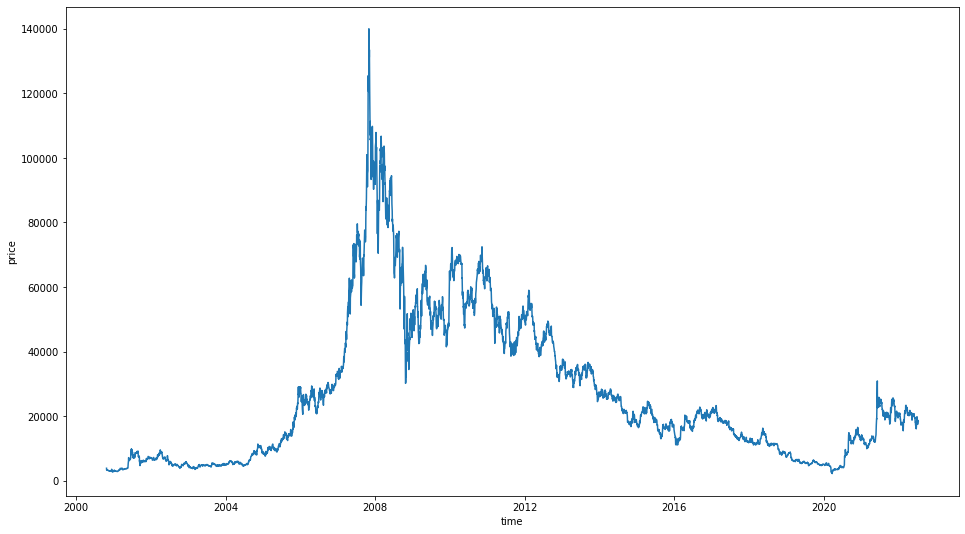

In [19]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

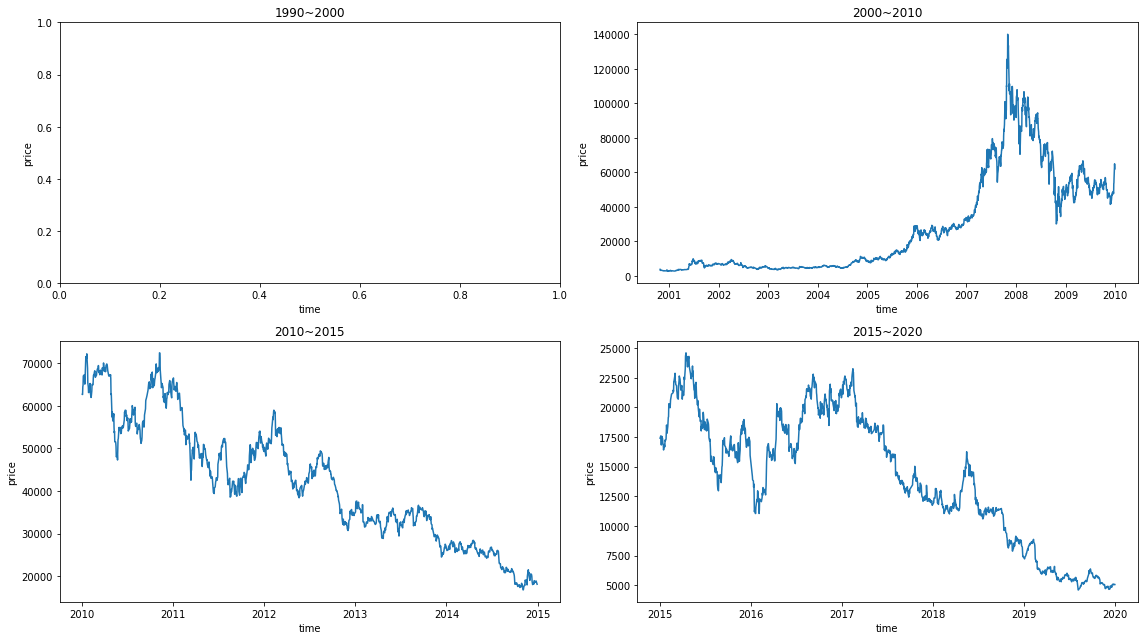

In [41]:
time_steps = [['1990', '2000'], # 특정기간을 설정하여 subplot 표현
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax) # 선형플롯
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # MinMaxScaler 인스턴스화

# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.01352501, 0.01534889, 0.01302351, 0.01192195, 0.07711252],
       [0.01190406, 0.0104683 , 0.00868234, 0.00793104, 0.04616138],
       [0.00876485, 0.00837464, 0.00862874, 0.00795281, 0.03384998],
       ...,
       [0.11711897, 0.11501265, 0.12002909, 0.11980002, 0.0852702 ],
       [0.12445357, 0.11674581, 0.12462292, 0.11871159, 0.04525772],
       [0.121153  , 0.11397275, 0.12232601, 0.11726035, 0.02945598]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [22]:
df = pd.DataFrame(scaled, columns=scale_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5363 non-null   float64
 1   High    5363 non-null   float64
 2   Low     5363 non-null   float64
 3   Close   5363 non-null   float64
 4   Volume  5363 non-null   float64
dtypes: float64(5)
memory usage: 209.6 KB


## train / test 분할

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [25]:
x_train.shape, y_train.shape

((4290, 4), (4290,))

In [26]:
x_test.shape, y_test.shape

((1073, 4), (1073,))

In [27]:
x_train

,Open,High,Low,Volume
0,0.013525,0.015349,0.013024,0.077113
1,0.011904,0.010468,0.008682,0.046161
2,0.008765,0.008375,0.008629,0.033850
3,0.008486,0.008423,0.008927,0.018232
4,0.008420,0.007231,0.007457,0.015307
...,...,...,...,...
4285,0.068806,0.064675,0.070722,0.004875
4286,0.070486,0.066006,0.072184,0.003953
4287,0.070486,0.066262,0.072483,0.003142
4288,0.068520,0.065208,0.070423,0.005406


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [28]:
import tensorflow as tf

In [29]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [30]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [31]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [32]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [34]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [35]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [36]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    130/Unknown - 16s 7ms/step - loss: 0.0014 - mse: 0.0027
Epoch 1: val_loss improved from inf to 0.00004, saving model to tmp/ckeckpointer.ckpt
134/134 [==============================] - 17s 15ms/step - loss: 0.0013 - mse: 0.0027 - val_loss: 4.2468e-05 - val_mse: 8.4936e-05
Epoch 2/50
126/134 [===========================>..] - ETA: 0s - loss: 2.7728e-04 - mse: 5.5455e-04
Epoch 2: val_loss improved from 0.00004 to 0.00004, saving model to tmp/ckeckpointer.ckpt
134/134 [==============================] - 1s 8ms/step - loss: 2.6732e-04 - mse: 5.3464e-04 - val_loss: 3.7017e-05 - val_mse: 7.4035e-05
Epoch 3/50
129/134 [===========================>..] - ETA: 0s - loss: 2.4296e-04 - mse: 4.8593e-04
Epoch 3: val_loss did not improve from 0.00004
134/134 [==============================] - 1s 8ms/step - loss: 2.3965e-04 - mse: 4.7930e-04 - val_loss: 3.9267e-05 - val_mse: 7.8533e-05
Epoch 4/50
127/134 [===========================>..] - ETA: 0s - loss: 2.3016e-04 - mse: 4.6032e-04
Epoc

저장한 ModelCheckpoint 를 로드합니다.

In [37]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [38]:
pred = model.predict(test_data)

In [39]:
pred.shape

(1053, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

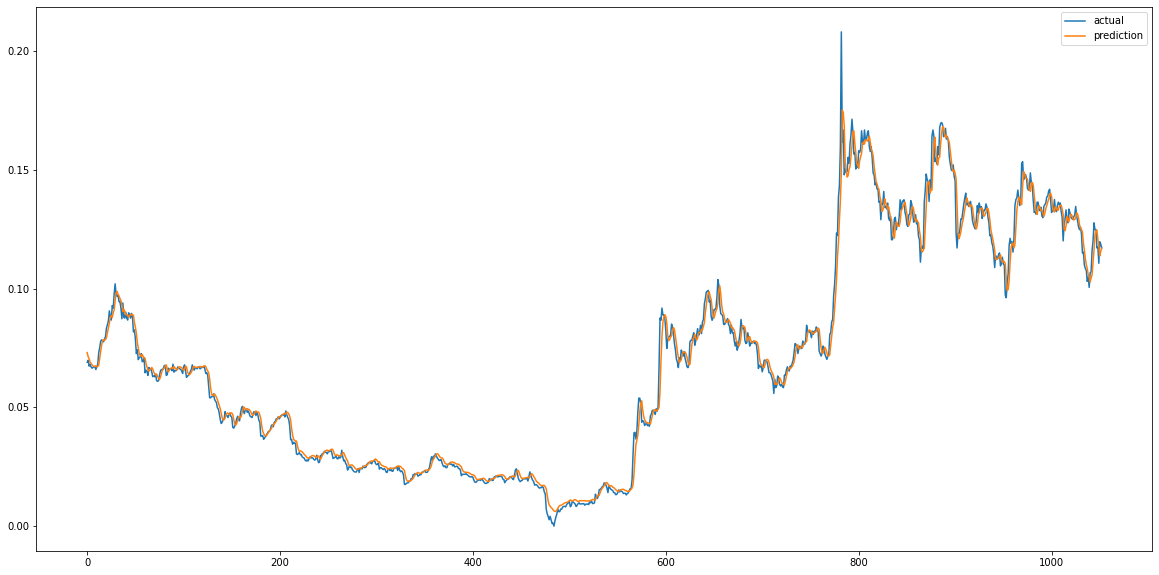

In [40]:
plt.figure(figsize=(20, 10))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()